In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/DATA SET/augISIC3Class/base_dir.zip', 'r')
zip_ref.extractall('/content/base_dir')
zip_ref.close()

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [ ]:
import shutil

In [ ]:
shutil.rmtree('/content/base_dir/val/Vascular lesion')

In [5]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/base_dir/train',
    labels='inferred',
    label_mode = 'categorical',
    batch_size=32,
    image_size=(224,224)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/base_dir/test',
    labels='inferred',
    label_mode = 'categorical',
    batch_size=32,
    image_size=(224,224)
)

Found 29822 files belonging to 3 classes.
Found 652 files belonging to 3 classes.


In [6]:
# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

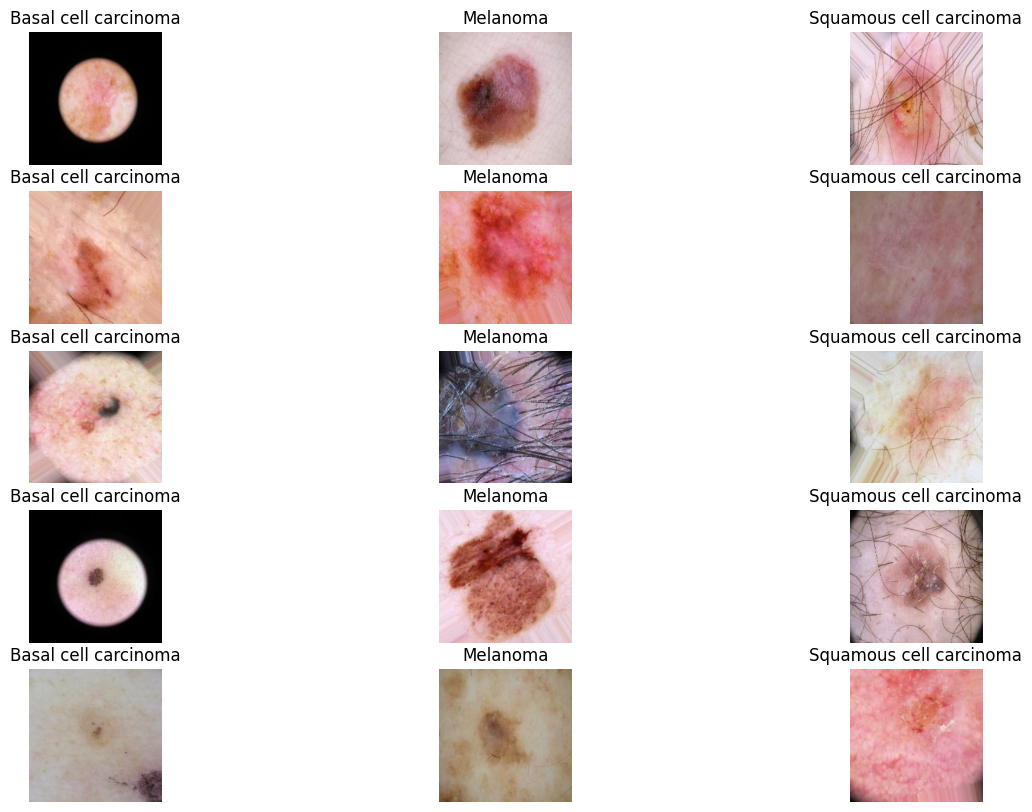

In [7]:
import os
import matplotlib.pyplot as plt
import random
from tensorflow import keras

# Define the train directory
train_directory = '/content/base_dir/train'

# Define class names
class_names = os.listdir(train_directory)

# Create a subdirectory for each class
class_subdirectories = [os.path.join(train_directory, cls) for cls in class_names]

# Display 5 random images from each class
num_images_to_display = 5

plt.figure(figsize=(15, 10))

for i, class_directory in enumerate(class_subdirectories):
    class_name = class_names[i]
    image_files = os.listdir(class_directory)
    random.shuffle(image_files)
    image_files = image_files[:num_images_to_display]

    for j, image_file in enumerate(image_files):
        image_path = os.path.join(class_directory, image_file)
        img = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))

        plt.subplot(num_images_to_display, len(class_names), j * len(class_names) + i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

plt.show()

Class 'Basal cell carcinoma': 9960 images
Class 'Melanoma': 9974 images
Class 'Squamous cell carcinoma': 9888 images


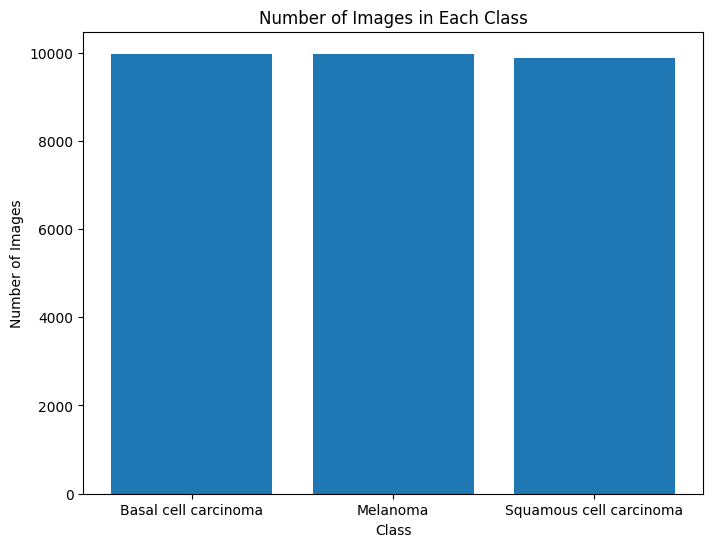

In [24]:
import os
import matplotlib.pyplot as plt

# Path to the train directory
train_dir = '/content/base_dir/train'

# List of class names (assuming subdirectories represent classes)
class_names = os.listdir(train_dir)

# Initialize a dictionary to store the count of images in each class
class_counts = {}

# Count the number of images in each class and print it
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    num_images = len(os.listdir(class_path))
    class_counts[class_name] = num_images
    print(f"Class '{class_name}': {num_images} images")

# Extract class names and counts
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Create a bar graph
plt.figure(figsize=(8, 6))
plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pre-trained ResNet-50 model (include_top=False omits the top classification layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)  # Output layer for 7 classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Print model summary
model.summary()


94765736/94765736 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [9]:
num_layers = len(model.layers)
print("Total number of layers in the model:", num_layers)

Total number of layers in the model: 179


In [10]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # You can adjust the learning rate as needed
    loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
    metrics=['accuracy']
)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define the callbacks
# Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the best weights when training stops
)
# Model Checkpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Trained Models/ResNet50onISICPre3Classes/best_model.h5',  # Filepath to save the best model
    monitor='val_loss',      # Monitor validation loss
    save_best_only=True,     # Save only the best model
    mode='min'               # Minimize the monitored quantity (val_loss)
)

# Reduce Learning Rate on Plateau callback
reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    #factor=0.5,          # Factor by which the learning rate will be reduced (0.5 means halving the learning rate)
    patience=2,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-5          # Minimum learning rate (to avoid reducing it too much)
)

In [12]:
# Specify the number of epochs and batch size
epochs = 50
batch_size = 32

# Use the fit method to train the model with the defined callbacks
history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=validation_ds,
    callbacks=[early_stopping, model_checkpoint, reduce_lr_on_plateau]
)

Epoch 1/50
932/932 [==============================] - ETA: 0s - loss: 0.8764 - accuracy: 0.5987

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


932/932 [==============================] - 363s 337ms/step - loss: 0.8764 - accuracy: 0.5987 - val_loss: 1.2811 - val_accuracy: 0.6457 - lr: 0.0010
Epoch 2/50
932/932 [==============================] - 317s 339ms/step - loss: 0.6758 - accuracy: 0.7095 - val_loss: 0.6726 - val_accuracy: 0.7638 - lr: 0.0010
Epoch 3/50
932/932 [==============================] - 307s 329ms/step - loss: 0.5664 - accuracy: 0.7621 - val_loss: 0.7719 - val_accuracy: 0.6963 - lr: 0.0010
Epoch 4/50
932/932 [==============================] - 317s 339ms/step - loss: 0.5299 - accuracy: 0.7847 - val_loss: 0.6053 - val_accuracy: 0.8113 - lr: 0.0010
Epoch 5/50
932/932 [==============================] - 311s 333ms/step - loss: 0.4752 - accuracy: 0.8105 - val_loss: 0.6139 - val_accuracy: 0.7653 - lr: 0.0010
Epoch 6/50
932/932 [==============================] - 318s 341ms/step - loss: 0.4304 - accuracy: 0.8298 - val_loss: 0.6031 - val_accuracy: 0.8083 - lr: 0.0010
Epoch 7/50
932/932 [==============================] - 312

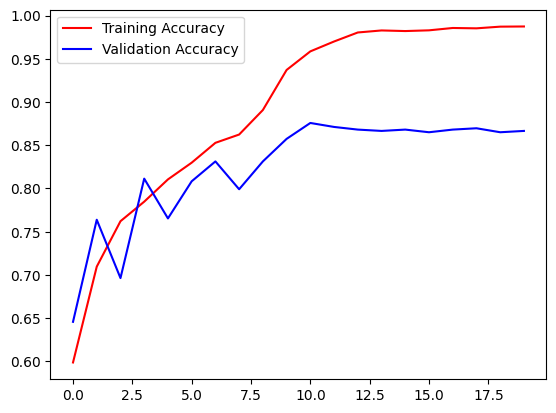

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='Training Accuracy')
plt.plot(history.history['val_accuracy'],color='blue',label='Validation Accuracy')
plt.legend()
plt.show()

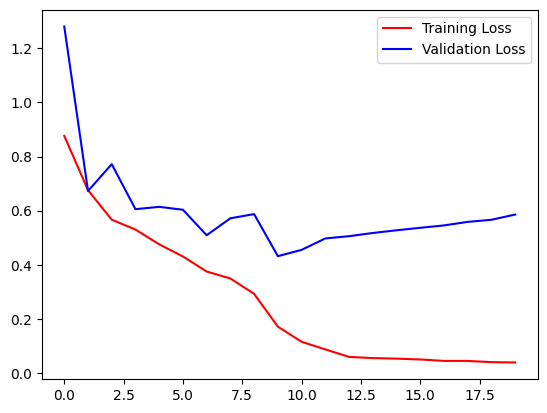

In [14]:
plt.plot(history.history['loss'],color='red',label='Training Loss ')
plt.plot(history.history['val_loss'],color='blue',label='Validation Loss')
plt.legend()
plt.show()

In [19]:
print("Best Epoch:\nEpoch 10/50 932/932 [==============================] - 311s 333ms/step - loss: 0.1708 - accuracy: 0.9371 - val_loss: 0.4315 - val_accuracy: 0.8574 - lr: 1.0000e-04")

Best Epoch:
Epoch 10/50 932/932 [==============================] - 311s 333ms/step - loss: 0.1708 - accuracy: 0.9371 - val_loss: 0.4315 - val_accuracy: 0.8574 - lr: 1.0000e-04


In [16]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, roc_auc_score, roc_curve, auc
from scipy.stats import hmean, gmean

# Define your model and training process here

# Define your validation dataset
validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/base_dir/val',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224)
)

# Normalize the validation data
def process(image, label):
    image = tf.cast(image / 255., tf.float32)
    return image, label

validation_ds = validation_ds.map(process)

# Make predictions on the validation dataset
y_true = []
y_pred_probs = []

for images, labels in validation_ds:
    y_true.extend(tf.argmax(labels, axis=1).numpy())  # True labels
    predictions = model.predict(images)
    y_pred_probs.extend(predictions)  # Predicted probabilities

# Convert predicted probabilities to class labels
y_pred = [tf.argmax(prob).numpy() for prob in y_pred_probs]

# Calculate the confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# True Positives, False Positives, True Negatives, False Negatives
tp = confusion[1, 1]
fp = confusion[0, 1]
tn = confusion[0, 0]
fn = confusion[1, 0]

# Sensitivity (True Positive Rate)
sensitivity = tp / (tp + fn)

# Specificity (True Negative Rate)
specificity = tn / (tn + fp)

# Precision
precision = tp / (tp + fp)

# F1-Score
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

# Error Rate
error_rate = (fp + fn) / (tp + fp + tn + fn)

# Matthews Correlation Coefficient
matthews_corr = matthews_corrcoef(y_true, y_pred)

# Geometric Mean
geometric_mean = gmean([sensitivity, specificity])

# Bookmaker Informedness
bookmaker_informedness = sensitivity + specificity - 1

# Display the metrics
print("Confusion Matrix:")
print(confusion)
print("Accuracy:", (tp + tn) / (tp + tn + fp + fn))
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("F1-Score:", f1_score)
print("Precision:", precision)
print("Error Rate:", error_rate)
print("Matthews Correlation Coefficient:", matthews_corr)
print("Geometric Mean:", geometric_mean)
print("Bookmaker Informedness:", bookmaker_informedness)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))


Found 648 files belonging to 3 classes.
1/1 [==============================] - 2s 2s/step
Confusion Matrix:
[[224  25   4]
 [ 22 325   3]
 [ 11   8  26]]
Accuracy: 0.9211409395973155
Sensitivity: 0.9365994236311239
Specificity: 0.8995983935742972
F1-Score: 0.9325681492109038
Precision: 0.9285714285714286
Error Rate: 0.07885906040268456
Matthews Correlation Coefficient: 0.7930922035541682
Geometric Mean: 0.9179124887053077
Bookmaker Informedness: 0.836197817205421
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       253
           1       0.91      0.93      0.92       350
           2       0.79      0.58      0.67        45

    accuracy                           0.89       648
   macro avg       0.86      0.80      0.82       648
weighted avg       0.89      0.89      0.89       648



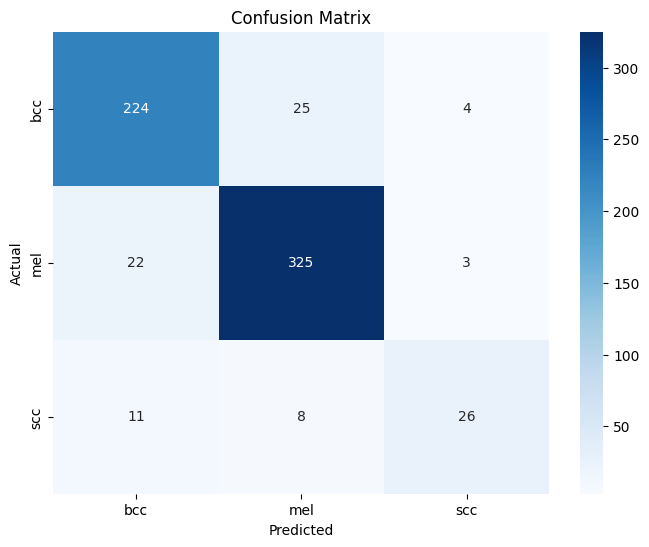

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# Define your class names
class_names = ['bcc', 'mel', 'scc']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,  # Use class names as x-axis labels
            yticklabels=class_names)  # Use class names as y-axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [27]:
import tensorflow as tf
from tensorflow import keras

# Load your trained model
#model = keras.models.load_model('your_model_path.h5')

# Define a function to preprocess an image
def preprocess_image(image_path):
    # Load and preprocess the image (you might need to adjust preprocessing based on your training data)
    img = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array

# Make predictions on a new image
image_path = '/content/base_dir/val/Basal cell carcinoma/ISIC_0024984.jpg'
preprocessed_image = preprocess_image(image_path)
predictions = model.predict(preprocessed_image)

# Interpret the predictions to determine the class
class_names = ['bcc', 'mel', 'scc']  # Replace with your class names
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
predicted_class = class_names[predicted_class_index]

print(f'The model predicts that the image belongs to class: {predicted_class}')

1/1 [==============================] - 0s 37ms/step
The model predicts that the image belongs to class: bcc
